## Setting

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import standard python libraries
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os, subprocess

from coolpuppy import coolpup
from coolpuppy.lib import numutils
from coolpuppy.lib.puputils import divide_pups
from coolpuppy import plotpup
import cooler
import bioframe
import cooltools
from cooltools import expected_cis, expected_trans
from cooltools.lib import plotting

import warnings

# Suppress FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)


# Functions for generalization

In [3]:
import copy

def callAPAoverLoop(coolFileDir, coolFileName, loopFileDir, loopFileName, minDist, minDiag, byDistance, balance, ooe):
    # minDist = minimun distance in kb to plot in APA
    # Load cool file
    cool_file = coolFileDir + '/' + coolFileName + '_KR.cool'
    clr = cooler.Cooler(f'{cool_file}')
    # Load loop file
    loop_file = loopFileDir + '/' + loopFileName + '.bedpe'
    loop = pd.read_csv(loop_file, sep = '\t', header = None).iloc[:, :6]
    loop.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']
    # Load expected table
    exp_file = coolFileDir + '/' + coolFileName + '_KR_exp.tsv'
    exp_df = pd.read_csv(exp_file, delimiter='\t')

    # Pileup
    if ooe:
        pup = coolpup.pileup(clr, loop, features_format = 'bedpe',
                             min_diag = minDiag, mindist = minDist*1000, by_distance = byDistance,
                             nproc = 12, 
                             clr_weight_name = balance,
                             ooe = True, expected_df = exp_df)
    else:
         pup = coolpup.pileup(clr, loop, features_format = 'bedpe',
                             min_diag = minDiag, mindist = minDist*1000, by_distance = byDistance,
                             nproc = 12, 
                             clr_weight_name = balance,
                             ooe = False)       

    return pup

def get_corner_score(pup, flank = 1):
    amap = pup["data"][0]
    c = amap.shape[0] / (flank*2 + 1)
    c = int(c)
    central = np.nanmean(amap[flank*c:-flank:c, flank*c:-flank*c])
    topRight = np.nanmean(amap[:c, -c:])
    cornerScore = central/topRight
    return cornerScore, central, topRight, 


def drawAPA(pup, scale, colormap, vmax, vmin, fileDir, fileName):
    puptemp = copy.deepcopy(pup)
    if scale == 'log2':
        puptemp.data[0] = np.log2(puptemp.data[0])

    # Make figure
    # Enrichment score is calculated by ratio of C(obs/exp) to R (obs/exp) before doing any form of log transform
    if vmax == False:
        fg1 = plotpup.plot(puptemp,
                           cmap = colormap,
                           score = False, 
                           scale = 'linear', height = 1, plot_ticks = True, font_scale = 0.8)
        fg1.ax.text(s= "corner score: " + str(round(get_corner_score(pup, flank = 2)[0], 2)),
                   x=0.9*20,  y=0.9*20,
                   va="top", ha="right",
                   size=4)
    else:
        fg1 = plotpup.plot(puptemp,
                   cmap = colormap,
                   score = False, vmax = vmax, vmin = vmin,
                   scale = 'linear', height = 1, plot_ticks = True, font_scale = 0.8)
        fg1.ax.text(s= "corner score: " + str(round(get_corner_score(pup, flank = 2)[0], 2)),
                   x=0.9*20,  y=0.9*20,
                   va="top", ha="right",
                   size=4)
    file = fileDir + '/' + fileName + '.svg'
    fg1.savefig(file, format = 'svg')
    return True


# APA plot

In [4]:
# LOADING COOL FILE
coolDir = '/Volumes/UKJIN_SSD/data/cool_norm_pooled'
figDir = '/Volumes/UKJIN_SSD/figure/loop_analysis'
loopDir = '/Volumes/UKJIN_SSD/data/loop_analysis'


### Chromosight loops UP/NO/DOWN 

#### All loops

In [ ]:
res = 5000
vminmax_map = {
    'UP':   (0.6, 0),
    'NO':   (0.6, 0),
    'DOWN': (1.2, 0),
}
#for name in ['UP', 'NO', 'DOWN']:
set = "chromosight_score_all_dTAGvsDMSO_diffCutoff0.2"
for name in ['DOWN']:
    vmax, vmin = vminmax_map[name]
    for sample in ['G1DMSO_pooled', 'G1dTAG_pooled']:
        pup = callAPAoverLoop(coolDir, sample + '_' + str(res) + 'bp',
                              loopDir, set + '_' + name,
                              minDist = 50, minDiag = 21, byDistance = False,
                              balance = 'weight', ooe = True)
        fileName = 'APA_' + set + "_" + name + '_' + sample
        drawAPA(pup, scale = 'log2', colormap = 'coolwarm', vmax = False, vmin = False,
               fileDir = figDir, fileName = fileName)
        # drawAPA(pup, scale = 'log2', colormap = 'coolwarm', vmax = vmax, vmin = vmin,
        #         fileDir = figDir, fileName = fileName + '_vminmax')


#### Str loops

INFO:coolpuppy:('chr12', 'chr12'): 2
INFO:coolpuppy:('chr13', 'chr13'): 4
INFO:coolpuppy:('chr8', 'chr8'): 4
INFO:coolpuppy:('chr15', 'chr15'): 1
INFO:coolpuppy:('chr16', 'chr16'): 1
INFO:coolpuppy:('chr10', 'chr10'): 2
INFO:coolpuppy:('chr14', 'chr14'): 4
INFO:coolpuppy:('chr17', 'chr17'): 5
INFO:coolpuppy:('chr9', 'chr9'): 3
INFO:coolpuppy:('chrX', 'chrX'): 2
INFO:coolpuppy:('chr18', 'chr18'): 3
INFO:coolpuppy:('chr7', 'chr7'): 2
INFO:coolpuppy:('chr6', 'chr6'): 5
INFO:coolpuppy:('chr4', 'chr4'): 4
INFO:coolpuppy:('chr3', 'chr3'): 4
INFO:coolpuppy:('chr2', 'chr2'): 5
INFO:coolpuppy:('chr1', 'chr1'): 4
INFO:coolpuppy:('chr11', 'chr11'): 1
INFO:coolpuppy:Total number of piled up windows: 56
INFO:coolpuppy:Can't set both vmin and vmax and get symmetrical scale. Plotting non-symmetrical
INFO:coolpuppy:('chr12', 'chr12'): 2
INFO:coolpuppy:('chr13', 'chr13'): 4
INFO:coolpuppy:('chr9', 'chr9'): 3
INFO:coolpuppy:('chr8', 'chr8'): 4
INFO:coolpuppy:('chr10', 'chr10'): 2
INFO:coolpuppy:('chr15'

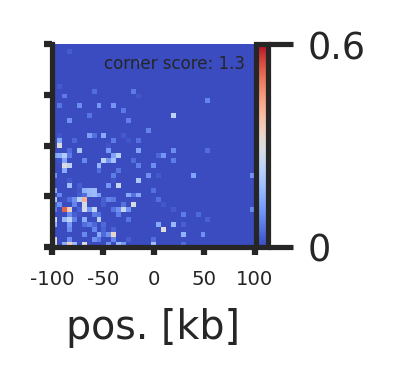

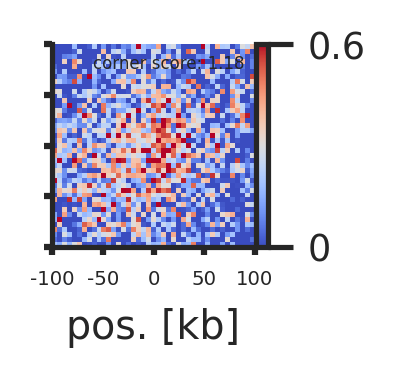

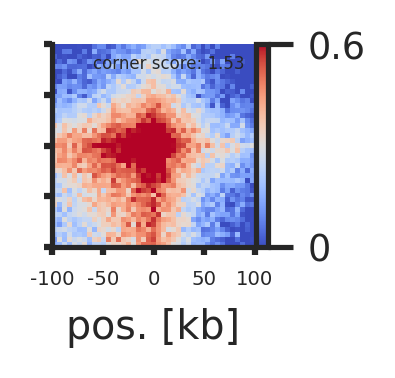

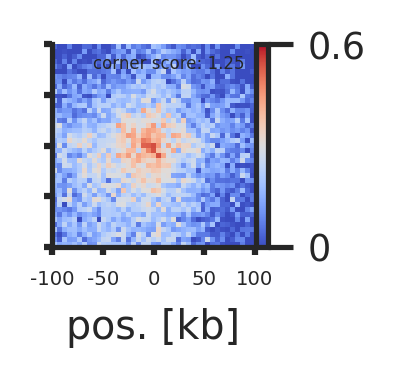

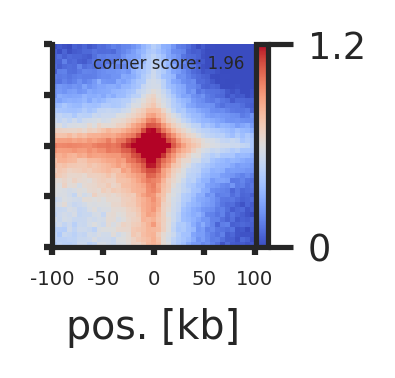

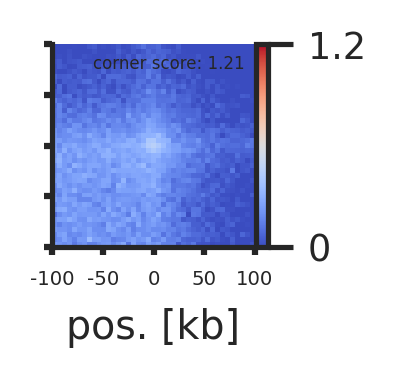

In [11]:
res = 5000
vminmax_map = {
    'UP':   (0.6, 0),
    'NO':   (0.6, 0),
    'DOWN': (1.2, 0),
}
#for name in ['UP', 'NO', 'DOWN']:
set = "chromosight_score_complex_str_dTAGvsDMSO_diffCutoff0.2"
for name in ['UP', 'NO', 'DOWN']:
    vmax, vmin = vminmax_map[name]
    for sample in ['G1DMSO_pooled', 'G1dTAG_pooled']:
        pup = callAPAoverLoop(coolDir, sample + '_' + str(res) + 'bp',
                              loopDir, set + '_' + name,
                              minDist = 50, minDiag = 21, byDistance = False,
                              balance = 'weight', ooe = True)
        fileName = 'APA_' + set + "_" + name + '_' + sample
        # drawAPA(pup, scale = 'log2', colormap = 'coolwarm', vmax = False, vmin = False,
        #        fileDir = figDir, fileName = fileName)
        drawAPA(pup, scale = 'log2', colormap = 'coolwarm', vmax = vmax, vmin = vmin,
                fileDir = figDir, fileName = fileName + '_vminmax')


#### Res loops

INFO:coolpuppy:('chr12', 'chr12'): 14
INFO:coolpuppy:('chr10', 'chr10'): 18
INFO:coolpuppy:('chr8', 'chr8'): 15
INFO:coolpuppy:('chr13', 'chr13'): 26
INFO:coolpuppy:('chr15', 'chr15'): 22
INFO:coolpuppy:('chr14', 'chr14'): 17
INFO:coolpuppy:('chr9', 'chr9'): 24
INFO:coolpuppy:('chr16', 'chr16'): 13
INFO:coolpuppy:('chr17', 'chr17'): 14
INFO:coolpuppy:('chr7', 'chr7'): 19
INFO:coolpuppy:('chr18', 'chr18'): 19
INFO:coolpuppy:('chr19', 'chr19'): 6
INFO:coolpuppy:('chr6', 'chr6'): 16
INFO:coolpuppy:('chrX', 'chrX'): 8
INFO:coolpuppy:('chr4', 'chr4'): 22
INFO:coolpuppy:('chr5', 'chr5'): 18
INFO:coolpuppy:('chr3', 'chr3'): 29
INFO:coolpuppy:('chr1', 'chr1'): 22
INFO:coolpuppy:('chr2', 'chr2'): 37
INFO:coolpuppy:('chr11', 'chr11'): 19
INFO:coolpuppy:Total number of piled up windows: 378
INFO:coolpuppy:Can't set both vmin and vmax and get symmetrical scale. Plotting non-symmetrical
INFO:coolpuppy:('chr12', 'chr12'): 14
INFO:coolpuppy:('chr8', 'chr8'): 15
INFO:coolpuppy:('chr13', 'chr13'): 26
I

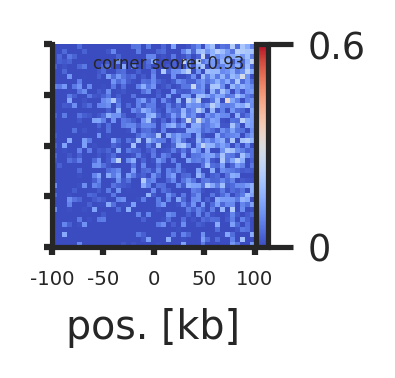

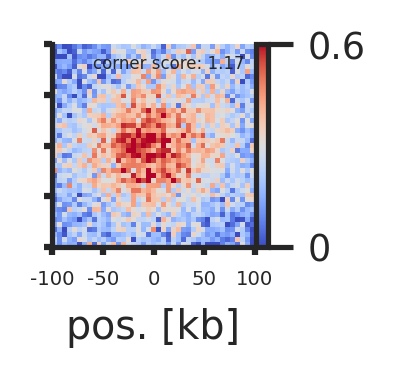

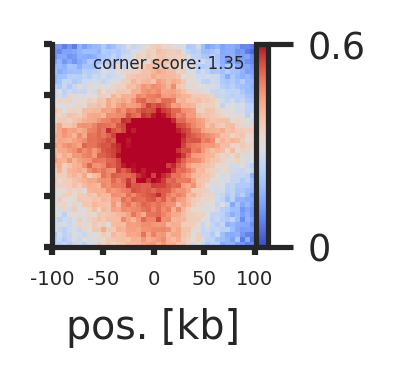

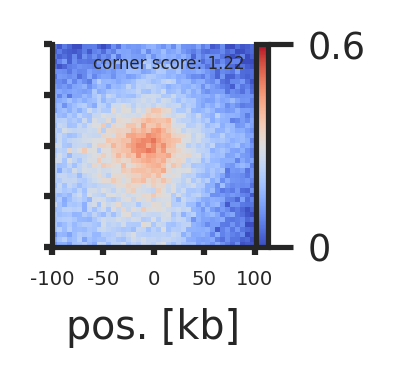

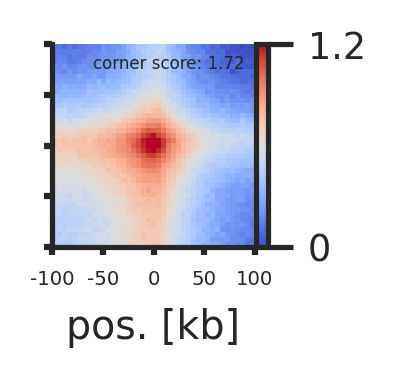

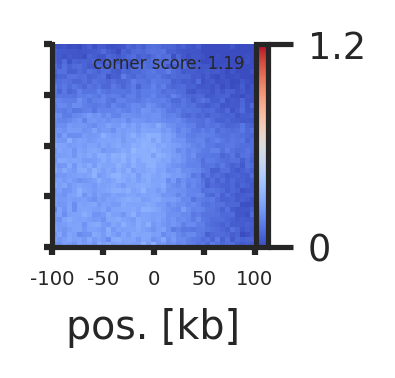

In [12]:
res = 5000
vminmax_map = {
    'UP':   (0.6, 0),
    'NO':   (0.6, 0),
    'DOWN': (1.2, 0),
}
#for name in ['UP', 'NO', 'DOWN']:
set = "chromosight_score_complex_reg_dTAGvsDMSO_diffCutoff0.2"
for name in ['UP', 'NO', 'DOWN']:
    vmax, vmin = vminmax_map[name]
    for sample in ['G1DMSO_pooled', 'G1dTAG_pooled']:
        pup = callAPAoverLoop(coolDir, sample + '_' + str(res) + 'bp',
                              loopDir, set + '_' + name,
                              minDist = 50, minDiag = 21, byDistance = False,
                              balance = 'weight', ooe = True)
        fileName = 'APA_' + set + "_" + name + '_' + sample
        # drawAPA(pup, scale = 'log2', colormap = 'coolwarm', vmax = False, vmin = False,
        #        fileDir = figDir, fileName = fileName)
        drawAPA(pup, scale = 'log2', colormap = 'coolwarm', vmax = vmax, vmin = vmin,
                fileDir = figDir, fileName = fileName + '_vminmax')


### EXPLORATORY

INFO:coolpuppy:('chr12', 'chr12'): 200
INFO:coolpuppy:('chr9', 'chr9'): 220
INFO:coolpuppy:('chr8', 'chr8'): 189
INFO:coolpuppy:('chr10', 'chr10'): 220
INFO:coolpuppy:('chr7', 'chr7'): 204
INFO:coolpuppy:('chr6', 'chr6'): 225
INFO:coolpuppy:('chr5', 'chr5'): 210
INFO:coolpuppy:('chr4', 'chr4'): 228
INFO:coolpuppy:('chr3', 'chr3'): 256
INFO:coolpuppy:('chr15', 'chr15'): 152
INFO:coolpuppy:('chr16', 'chr16'): 151
INFO:coolpuppy:('chr19', 'chr19'): 114
INFO:coolpuppy:('chr13', 'chr13'): 192
INFO:coolpuppy:('chr18', 'chr18'): 148
INFO:coolpuppy:('chrX', 'chrX'): 125
INFO:coolpuppy:('chr14', 'chr14'): 182
INFO:coolpuppy:('chr17', 'chr17'): 130
INFO:coolpuppy:('chr1', 'chr1'): 331
INFO:coolpuppy:('chr2', 'chr2'): 332
INFO:coolpuppy:('chr11', 'chr11'): 282
INFO:coolpuppy:Total number of piled up windows: 4091
INFO:coolpuppy:Can't set both vmin and vmax and get symmetrical scale. Plotting non-symmetrical
INFO:coolpuppy:('chr12', 'chr12'): 200
INFO:coolpuppy:('chr9', 'chr9'): 220
INFO:coolpuppy

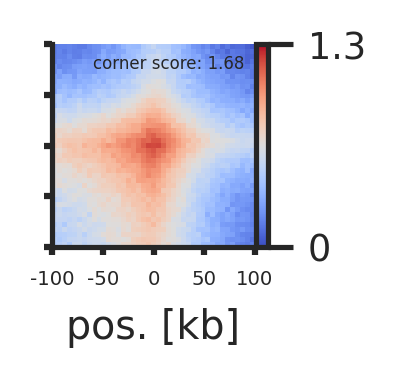

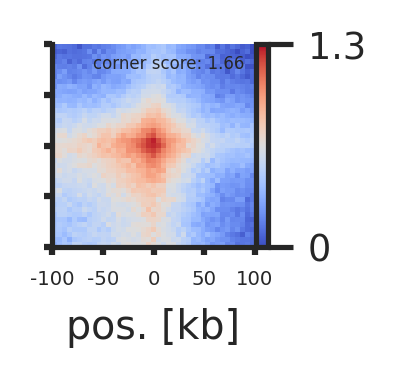

In [6]:
res = 5000

#for name in ['UP', 'NO', 'DOWN']:
vmax, vmin = (1.3, 0)
name = 'temp_EpiLCDMSO_onlyCalled'
for sample in ['G1DMSO_pooled', 'EpiG1DMSO_pooled']:
	pup = callAPAoverLoop(coolDir, sample + '_' + str(res) + 'bp',
							loopDir, name,
							minDist = 50, minDiag = 21, byDistance = False,
							balance = 'weight', ooe = True)
	fileName = "APA_" + name + '_' + sample
	# drawAPA(pup, scale = 'log2', colormap = 'coolwarm', vmax = False, vmin = False,
	#        fileDir = figDir, fileName = fileName)
	drawAPA(pup, scale = 'log2', colormap = 'coolwarm', vmax = vmax, vmin = vmin,
			fileDir = figDir, fileName = fileName + '_vminmax')